In [1]:
import pandas as pd
import numpy as np
import category_encoders as ce
import shap
import subprocess
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import IsolationForest
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from sklearn.feature_selection import RFE, mutual_info_regression
from sklearn.model_selection import train_test_split


/Users/kirillsobolev/Documents/GitHub/Advanced-data-analytics/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In exercise 1, I've already did some of feature engineering. However, I want to try again in do that in another way, that's why I will load almost original dataset with only some actions from exercise 1 perfomed (text categorical values untouched, so i can deal with them in another way avoiding multicolinarity).

In [2]:
df = pd.read_csv("cars.csv")
target = "price_levy_combined"
df.drop("Unnamed: 0",axis=1, inplace=True)
df

,Price,Levy,Manufacturer,Prod. year,Category,Leather interior,Fuel type,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Airbags,Engine volume int,Turbo
0,13328,1399,LEXUS,2010,Jeep,0,Hybrid,186005,6.0,Automatic,4x4,04-May,0,12,3.5,0.0
1,16621,1018,CHEVROLET,2011,Jeep,1,Petrol,192000,6.0,Tiptronic,4x4,04-May,0,8,3.0,0.0
2,8467,0,HONDA,2006,Hatchback,1,Petrol,200000,4.0,Variator,Front,04-May,1,2,1.3,0.0
3,3607,862,FORD,2011,Jeep,0,Hybrid,168966,4.0,Automatic,4x4,04-May,0,0,2.5,0.0
4,11726,446,HONDA,2014,Hatchback,0,Petrol,91901,4.0,Automatic,Front,04-May,0,4,1.3,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14545,470,645,TOYOTA,2011,Hatchback,0,Hybrid,307325,4.0,Automatic,Front,04-May,0,12,1.8,0.0
14546,8467,0,MERCEDES-BENZ,1999,Coupe,0,CNG,300000,4.0,Manual,Rear,02-Mar,0,5,2.0,1.0
14547,15681,831,HYUNDAI,2011,Sedan,0,Petrol,161600,4.0,Tiptronic,Front,04-May,0,8,2.4,0.0
14548,26108,836,HYUNDAI,2010,Jeep,0,Diesel,116365,4.0,Automatic,Front,04-May,0,4,2.0,0.0


<h1>Managing high cardinality</h1>

<h3>Price and levy. Additive interaction</h3>

In [3]:
# levy is some kind of additional fees or taxes, so it can be combined with a price
df["price_levy_combined"] = df["Price"] + df["Levy"]
df.drop(["Price", "Levy"],axis=1, inplace=True)

<h3>Manufacturer. Target encoding</h3>
In general, I believe that car manufacturers are known not only by name, but by price range as well. Everyone assumes that lexus costs more than honda.

In [4]:
encoder = ce.TargetEncoder(cols=["Manufacturer"])
df["manufacturer_encoded"] = encoder.fit_transform(df['Manufacturer'], df[target])
df.drop("Manufacturer", axis=1, inplace=True)

<h3>Category. Agglomerative clustering</h3>


In [5]:
# Assign number to each category with label encoder
le = LabelEncoder()
df['Category_encoded'] = le.fit_transform(df['Category'])


In [6]:
# Reorginize order of categories with agglomerative clustering
number_of_clusters = len(df.Category.unique())
agglo = AgglomerativeClustering(n_clusters=number_of_clusters)

df['Cluster'] = agglo.fit_predict(df[['Category_encoded']])

In [7]:
# evaluate the clustering quality with metrics
sil_score = silhouette_score(df[['Category_encoded']], df['Cluster'])
print(f"Silhouette score: {sil_score:.3f}")

ari_score = adjusted_rand_score(df['Category_encoded'], df['Cluster'])
print(f"Adjusted Rand score (ARI): {ari_score:.3f}")

# metrics should be close to 1

Silhouette score: 1.000
Adjusted Rand score (ARI): 1.000


In [8]:
df.drop(["Category_encoded", "Category"], axis=1, inplace=True)

<h3>Fuel Type, gear box type, drive wheels, doors. PCA</h3>
Let's one hot encode these features and then transform with PCA aiming to loose less than 10% variancy.

In [9]:
variables = ["Fuel type", "Gear box type", "Drive wheels", "Doors"]
pca_df = pd.get_dummies(df, columns=variables)
# Keep only encoded columns
pca_df = pca_df[['Fuel type_CNG', 'Fuel type_Diesel', 'Fuel type_Hybrid',
       'Fuel type_Hydrogen', 'Fuel type_LPG', 'Fuel type_Petrol',
       'Fuel type_Plug-in Hybrid', 'Gear box type_Automatic',
       'Gear box type_Manual', 'Gear box type_Tiptronic',
       'Gear box type_Variator', 'Drive wheels_4x4', 'Drive wheels_Front',
       'Drive wheels_Rear', 'Doors_02-Mar', 'Doors_04-May', 'Doors_>5']]
pca_df


,Fuel type_CNG,Fuel type_Diesel,Fuel type_Hybrid,Fuel type_Hydrogen,Fuel type_LPG,Fuel type_Petrol,Fuel type_Plug-in Hybrid,Gear box type_Automatic,Gear box type_Manual,Gear box type_Tiptronic,Gear box type_Variator,Drive wheels_4x4,Drive wheels_Front,Drive wheels_Rear,Doors_02-Mar,Doors_04-May,Doors_>5
0,False,False,True,False,False,False,False,True,False,False,False,True,False,False,False,True,False
1,False,False,False,False,False,True,False,False,False,True,False,True,False,False,False,True,False
2,False,False,False,False,False,True,False,False,False,False,True,False,True,False,False,True,False
3,False,False,True,False,False,False,False,True,False,False,False,True,False,False,False,True,False
4,False,False,False,False,False,True,False,True,False,False,False,False,True,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14545,False,False,True,False,False,False,False,True,False,False,False,False,True,False,False,True,False
14546,True,False,False,False,False,False,False,False,True,False,False,False,False,True,True,False,False
14547,False,False,False,False,False,True,False,False,False,True,False,False,True,False,False,True,False
14548,False,True,False,False,False,False,False,True,False,False,False,False,True,False,False,True,False


In [10]:
# Amount of PCA components
# Could also use 9 components (5% loss) or even 8 (close to 10% loss)
num_components = 10
# Initialize PCA
pca = PCA(n_components=num_components)
# Fit
X_pca = pca.fit_transform(pca_df)

# Metrics
explained_variance_ratio = pca.explained_variance_ratio_
print(f"Explained variance ratio with {num_components} components, by each component:\n{explained_variance_ratio}")
print(f"\nExplained variance ratio with {num_components} components, total result:\n{sum(explained_variance_ratio)}")
# Reconstruct to measure MSE
X_reconstructed = pca.inverse_transform(X_pca)
#  MSE => keep this as close to 0 as possible
# basically measures how much error the PCA model makes compared to original data
mse = mean_squared_error(pca_df, X_reconstructed)
print(f"\nMean Squared Error (MSE) between original and reconstructed data:\n{mse}")


Explained variance ratio with 10 components, by each component:
[0.26603284 0.18852088 0.15259935 0.11414787 0.08240663 0.06620054
 0.04279945 0.03180329 0.02798971 0.01716896]

Explained variance ratio with 10 components, total result:
0.9896695210231163

Mean Squared Error (MSE) between original and reconstructed data:
0.0010193239915966509


In [11]:
# Transform X_pca from np.ndarray to dataframe to be able to concatenate
X_pca = pd.DataFrame(X_pca)


In [12]:
# Concatenate PCA components to original df while deleting original columns
df = pd.concat([df.drop(variables, axis=1), X_pca], axis=1)
# Change type of column names to str (otherwise some instruments refuse to work)
df.columns = df.columns.astype(str)

<h1>Feature importance</h1>
Before evaluating the feature importance let's check for outliers

In [13]:
iso = IsolationForest(contamination=0.05) 
# fit isolation forest
y_pred = iso.fit_predict(df)

# filter outliers only
outliers = df[y_pred != 1]
df.drop(outliers.index, inplace=True)

<h3>Recursive Feature Elimination</h3>

In [14]:
X = df.drop(target, axis=1)
y = df[target]



In [15]:
model = XGBRegressor()
# create RFE, place the model and choose amount of optimal variables
rfe = RFE(estimator=model, n_features_to_select=15)

In [16]:
rfe.fit(X, y)

RFE(estimator=XGBRegressor(base_score=None, booster=None, callbacks=None,
                           colsample_bylevel=None, colsample_bynode=None,
                           colsample_bytree=None, device=None,
                           early_stopping_rounds=None, enable_categorical=False,
                           eval_metric=None, feature_types=None, gamma=None,
                           grow_policy=None, importance_type=None,
                           interaction_constraints=None, learning_rate=None,
                           max_bin=None, max_cat_threshold=None,
                           max_cat_to_onehot=None, max_delta_step=None,
                           max_depth=None, max_leaves=None,
                           min_child_weight=None, missing=nan,
                           monotone_constraints=None, multi_strategy=None,
                           n_estimators=None, n_jobs=None,
                           num_parallel_tree=None, random_state=None, ...),
    n_features_to_select=15)

In [17]:
# get rankings and the results
rankings = rfe.ranking_
support = rfe.support_

# build a new DataFrame just to show results of RFE
results_df = pd.DataFrame({
    "Feature": X.columns,
    "Ranking": rankings,
    "Selected": support
}).sort_values(by="Ranking")

# these results accompanied with any other knowledge you
# have regarding dataset (other analysis tools but also domain knowledge)
# you can decide the most important variables
results_df

,Feature,Ranking,Selected
0,Prod. year,1,True
17,7,1,True
16,6,1,True
14,4,1,True
12,2,1,True
11,1,1,True
10,0,1,True
18,8,1,True
9,Cluster,1,True
7,Turbo,1,True


<h3>Mutual Information</h3>

In [18]:
# fit the mutual information algorithm
mi = mutual_info_regression(X, y)

# convert results into DataFrame
mi_results = pd.Series(mi, index=X.columns).sort_values(ascending=False)

mi_results

# high value => variable is strongly connected to target variable
# low value => weak connection
# very similar to phik-matrix

Prod. year              0.518370
Engine volume int       0.420466
0                       0.402831
9                       0.401382
4                       0.400403
3                       0.399478
7                       0.398108
8                       0.397577
5                       0.394699
2                       0.394268
6                       0.394180
1                       0.389973
manufacturer_encoded    0.341276
Airbags                 0.323770
Cluster                 0.175587
Leather interior        0.143276
Mileage                 0.124619
Wheel                   0.094207
Cylinders               0.058941
Turbo                   0.039718
dtype: float64

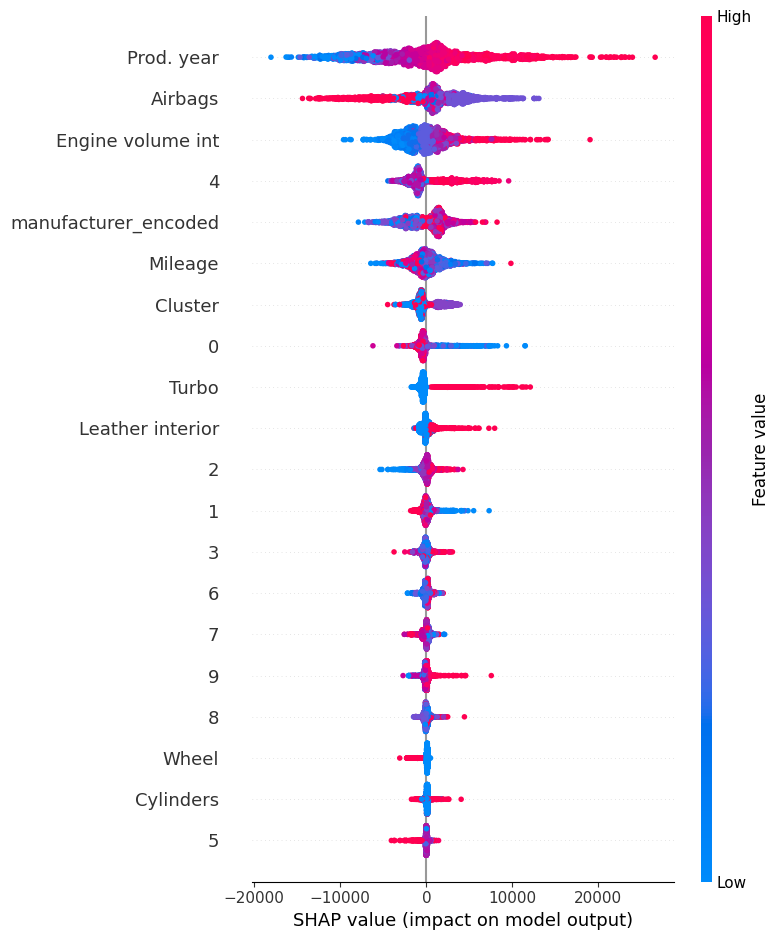

Feature Importances using SHAP:
                 Feature   Importance
0             Prod. year  4779.108887
1       Leather interior   475.728668
2                Mileage  1228.480957
3              Cylinders   177.532822
4                  Wheel   179.918915
5                Airbags  3053.072754
6      Engine volume int  2126.374023
7                  Turbo   786.327209
8   manufacturer_encoded  1815.558594
9                Cluster  1141.150879
10                     0   796.839233
11                     1   384.782990
12                     2   451.556885
13                     3   331.251373
14                     4  1920.574707
15                     5   129.395340
16                     6   289.542084
17                     7   280.422241
18                     8   196.115906
19                     9   207.932251


In [19]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Train model
model = XGBRegressor()
model.fit(X_train, y_train)

# Initialize SHAP explainer
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Plot SHAP summary
shap.summary_plot(shap_values, X_test)

# Feature importance
importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': np.mean(np.abs(shap_values), axis=0)
})
print("Feature Importances using SHAP:")
print(importance)

In [20]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# convert all continuous variables to integer,
# and convert all negative numbers to 0
X_cat = X.astype(int)
X_cat = X_cat.clip(lower=0)

# initialize chi2 and SelectKBest
# Note: chi2 -test is a very common test
# in statistics and quantitative analysis
# basically it studies the data whether variables are related
# or independent of each other
chi_2_features = SelectKBest(chi2, k=len(X_cat.columns))

# fit our data to the SelectKBest
best_features = chi_2_features.fit(X_cat,y.astype(int))

# use decimal format in table print later
pd.options.display.float_format = '{:.2f}'.format

# wrap it up, and show the results
# the higher the score, the more effect that column has on price
df_features = pd.DataFrame(best_features.scores_)
df_columns = pd.DataFrame(X_cat.columns)
f_scores = pd.concat([df_columns,df_features],axis=1)
f_scores.columns = ['Features','Score']
f_scores.sort_values(by='Score',ascending=False)

,Features,Score
2,Mileage,388522588.63
8,manufacturer_encoded,13107742.23
5,Airbags,22270.70
13,3,9060.50
9,Cluster,8839.05
7,Turbo,6261.32
4,Wheel,5969.81
1,Leather interior,5956.30
6,Engine volume int,3235.21
3,Cylinders,1626.68


Interesting that half of the tools used says that PCA components are important, and half of them are clearly doesn't like them.
But in general, I think cylinders and wheel are not so important according to all of them. 

Select K best is a bit weird, it loves mileage more than everythijng else, but doesn't even work with PVA components...

In [21]:
df.drop(["Cylinders", "Wheel"], axis=1, inplace=True)

In [22]:
df

,Prod. year,Leather interior,Mileage,Airbags,Engine volume int,Turbo,price_levy_combined,manufacturer_encoded,Cluster,0,1,2,3,4,5,6,7,8,9
0,2010,0,186005,12,3.50,0.00,14727,21016.64,4,0.12,-0.40,-0.93,1.12,-0.23,-0.18,-0.08,-0.05,-0.23,-0.09
1,2011,1,192000,8,3.00,0.00,17639,16188.57,4,-1.40,-0.10,-0.20,0.46,0.55,-0.17,-0.05,-0.02,-0.08,-0.05
2,2006,1,200000,2,1.30,0.00,8467,15471.74,7,-0.28,0.27,0.67,-0.02,-0.08,-0.43,0.33,-0.50,0.79,0.09
3,2011,0,168966,0,2.50,0.00,4469,15549.98,4,0.12,-0.40,-0.93,1.12,-0.23,-0.18,-0.08,-0.05,-0.23,-0.09
4,2014,0,91901,4,1.30,0.00,12172,15471.74,7,0.19,0.70,0.04,-0.17,-0.01,0.02,0.03,-0.01,-0.01,0.02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14544,2008,1,150000,6,1.50,0.00,50,16579.72,7,0.84,-0.12,0.13,0.68,-0.30,0.11,-0.07,0.00,-0.23,-0.04
14545,2011,0,307325,12,1.80,0.00,1115,16579.72,7,0.84,-0.12,0.13,0.68,-0.30,0.11,-0.07,0.00,-0.23,-0.04
14547,2011,0,161600,8,2.40,0.00,16512,23893.30,2,-0.68,0.17,0.86,0.02,0.48,0.12,-0.04,0.02,-0.09,0.00
14548,2010,0,116365,4,2.00,0.00,26944,23893.30,4,0.83,-0.44,-0.19,-0.44,0.38,0.09,-0.04,-0.11,0.02,0.02


In the end, I think multicollinearity is handled quite well. After exercise 1 i had a dataset, where almost everything was basically OneHot encoded and most of the categories were assumed rare and joined together into "other group". Now, instead of very average country of origin, I have target encoded manufacturer. Same goes for car category, now it's clustered. By that I think I've managed to save some pieces of data.

I liked PCA components, by that I reduced potential amount of unbalanced columns. And now afterwards I think I should've also combined all car characteristics, such as leather interior, turbo, engine volume and airbags.

I suppose that dataset now looks completely different and it's quite hard to compare averages, deviations etc. But I believe I almost didn't change the data itself and the representation should be close to the original dataset.

